In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer #for converting into binary form
from keras.models import Sequential #for Sequential model generation
from keras.layers.normalization import BatchNormalization #for normalizing
from keras.layers.convolutional import Conv2D #for convolution layer
from keras.layers.convolutional import MaxPooling2D #for max pooling layer
from keras.layers.core import Activation, Flatten, Dropout, Dense #for dense ,flatten,activation
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator #for generating image data
from keras.optimizers import Adam #for optimizing our model
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
!pip3 install setproctitle
!pip3 install redis
!pip3 install ray
!pip install tensorflow

mxnet 1.3.0.post0 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.15.2 which is incompatible.
kmeans-smote 0.1.0 has requirement imbalanced-learn<0.4,>=0.3.1, but you'll have imbalanced-learn 0.5.0.dev0 which is incompatible.
kmeans-smote 0.1.0 has requirement numpy<1.15,>=1.13, but you'll have numpy 1.15.2 which is incompatible.
fastai 0.7.0 has requirement torch<0.4, but you'll have torch 0.4.1 which is incompatible.
anaconda-client 1.7.2 has requirement python-dateutil>=2.6.1, but you'll have python-dateutil 2.6.0 which is incompatible.
imbalanced-learn 0.5.0.dev0 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.1 which is incompatible.
You are using pip version 10.0.1, however version 21.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
mxnet 1.3.0.post0 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.15.2 which is incompatible.
kmeans-smote 0.1.0 has requirement imbalanced-learn<0.4,>=0.3.1

In [3]:
import setproctitle
import redis
import ray

In [4]:
ray.init(ignore_reinit_error=True)

Process STDOUT and STDERR is being redirected to /tmp/raylogs/.
Waiting for redis server at 127.0.0.1:48301 to respond...
Waiting for redis server at 127.0.0.1:13694 to respond...
Starting the Plasma object store with 0.00 GB memory.
Starting local scheduler with the following resources: {'CPU': 4, 'GPU': 0}.

View the web UI at http://localhost:8892/notebooks/ray_ui45230.ipynb?token=1ca092812ecef68640b9f1b09fd8a8192e74553b3c10305f



{'node_ip_address': '172.19.2.2',
 'redis_address': '172.19.2.2:48301',
 'object_store_addresses': [ObjectStoreAddress(name='/tmp/plasma_store81720157', manager_name='/tmp/plasma_manager13464422', manager_port=65396)],
 'local_scheduler_socket_names': ['/tmp/scheduler13374148'],
 'raylet_socket_names': [],
 'webui_url': 'http://localhost:8892/notebooks/ray_ui45230.ipynb?token=1ca092812ecef68640b9f1b09fd8a8192e74553b3c10305f'}

In [5]:
import time
print("Timer started\n")
print("-----------------------------------------------------------------------------------------")
start = time.time()

Timer started

-----------------------------------------------------------------------------------------


Import neccessary packages

In [6]:
EPOCHS = 10
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '../input/plantvillage/'
width=256
height=256
depth=3

Function to convert images to array

In [7]:
@ray.remote(num_cpus=1)
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Fetch images from directory

In [8]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    df = ray.get(convert_image_to_array.remote(image_directory))
                    image_list.append(df)
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
Error : Could not get objectid ObjectID(ba357b546e317ef99423103cedfc3d044ead63e4). It was created by remote function __main__.convert_image_to_array which failed with:

Remote function __main__.convert_image_to_array failed with:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/ray/worker.py", line 965, in _process_task
    self._store_outputs_in_objstore(return_object_ids, outputs)
  File "/opt/conda/lib/python3.6/site-packages/ray/worker.py", line 891, in _store_outputs_in_objstore
    self.put_object(object_ids[i], outputs[i])
  File "/opt/conda/lib/python3.6/site-packages/ray/worker.py", line 406, in put_object
    self.store_and_register(object_id, value)
  File "/opt/conda/lib/python3.6/site-packages/ray/worker.py", line 341, in store

Remote function __main__.convert_image_to_array failed with:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/ray/worker.py", line 965, in _process_task
    self._store_outputs_in_objstore(return_object_ids, outputs)
  File "/opt/conda/lib/python3.6/site-packages/ray/worker.py", line 891, in _store_outputs_in_objstore
    self.put_object(object_ids[i], outputs[i])
  File "/opt/conda/lib/python3.6/site-packages/ray/worker.py", line 406, in put_object
    self.store_and_register(object_id, value)
  File "/opt/conda/lib/python3.6/site-packages/ray/worker.py", line 341, in store_and_register
    self.task_driver_id))
  File "/opt/conda/lib/python3.6/site-packages/ray/utils.py", line 387, in _wrapper
    return orig_attr(*args, **kwargs)
  File "pyarrow/_plasma.pyx", line 436, in pyarrow._plasma.PlasmaClient.put
  File "pyarrow/_plasma.pyx", line 340, in pyarrow._plasma.PlasmaClient.create
  File "pyarrow/error.pxi", line 99, in pyarrow.lib.check_status
pya

Get Size of Processed Image

In [9]:
image_size = len(image_list)

Transform Image Labels uisng [Scikit Learn](http://scikit-learn.org/)'s LabelBinarizer

In [10]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

Print the classes

In [11]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Potato___healthy' 'Tomato_Leaf_Mold'
 'Tomato__Tomato_YellowLeaf__Curl_Virus']


In [12]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [13]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [14]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [15]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

Model Summary

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 85, 85, 64)        0         
__________

In [17]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [18]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/10
17/17 [==============================] - 195s 11s/step - loss: 0.5677 - acc: 0.8460 - val_loss: 0.9268 - val_acc: 0.8180
Epoch 2/10
17/17 [==============================] - 191s 11s/step - loss: 0.3212 - acc: 0.8888 - val_loss: 1.6315 - val_acc: 0.7574
Epoch 3/10
17/17 [==============================] - 187s 11s/step - loss: 0.1808 - acc: 0.9274 - val_loss: 1.3250 - val_acc: 0.7555
Epoch 4/10
17/17 [==============================] - 188s 11s/step - loss: 0.1566 - acc: 0.9430 - val_loss: 0.5115 - val_acc: 0.8824
Epoch 5/10
17/17 [==============================] - 190s 11s/step - loss: 0.1513 - acc: 0.9462 - val_loss: 0.1779 - val_acc: 0.9467
Epoch 6/10
17/17 [==============================] - 188s 11s/step - loss: 0.1271 - acc: 0.9485 - val_loss: 1.5315 - val_acc: 0.8364
Epoch 7/10
17/17 [==============================] - 188s 11s/step - loss: 0.2272 - acc: 0.9233 - val_loss: 0.9855 - val_acc: 0.8548
Epoch 8/10
17/17 [==============================] - 190s 11s/step - loss: 0.

Plot the train and val curve

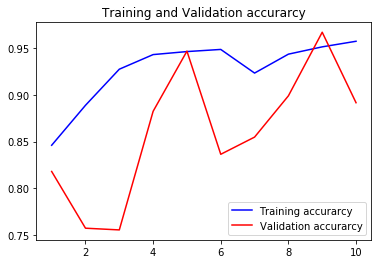

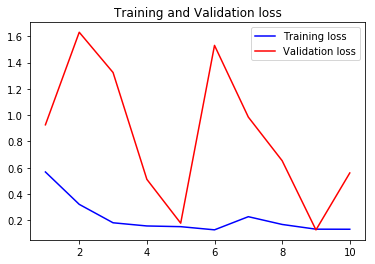

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Model Accuracy

In [20]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
136/136 [==============================] - 11s 81ms/step
Test Accuracy: 89.15441176470588


Save model using Pickle

In [21]:
print("--------------------------------------------------------------------------------------------")
end = time.time()
print("Time elapsed is {}".format(end-start)) # print time taken

--------------------------------------------------------------------------------------------
Time elapsed is 1926.4770166873932


In [22]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...
